In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cygnus_lib as cy
import mylib as my
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import scipy.stats as stats
from itertools import combinations
import math
%matplotlib inline
x_resolution = y_resolution = 2048
import os
import requests
import ROOT
import root_numpy as rtnp
ROOT.gROOT.SetBatch(True)

Welcome to JupyROOT 6.15/01


# LEMON Parameters

In [ ]:

# LEMON
phKev       = 1730/5.9
pixelscale  = 0.125 
run         = 2273 # 100 eventi pos 3
run         = 2277 # 1000 eventi pos 3
#run         = 2320 # AmBe
run         = 2318 # AmBe
run_ped     = 2151 
cimax       = 300
cimin       = 0 
dataSelection = 'LAB'
rescale = 512


xyscale = x_resolution/rescale
rescale_pixelscale = xyscale*pixelscale
print("Scale: %d Pixel/Mpixel, %.2f [mm/Mpixel]" % (xyscale, rescale_pixelscale))


# MANGO/ORANGE Parameters

In [57]:
# MANGO/ORANGE
phKev         = 10000/5.9
pixelscale    = 0.55 
run           = 2346
run_ped       = 2340 
cimax         = 300
cimin         = 0 
dataSelection = 'LAB'
rescale       = 512
nsigma        = 1.8

xyscale = x_resolution/rescale
rescale_pixelscale = xyscale*pixelscale
print("Scale: %d Pixel/Mpixel, %.2f [mm/Mpixel]" % (xyscale, rescale_pixelscale))


Scale: 4 Pixel/Mpixel, 2.20 [mm/Mpixel]


# Load File

In [55]:
print ('Download and open file: '+cy.swift_root_file(dataSelection, run))
tmp_file = cy.swift_download_file(cy.swift_root_file(dataSelection, run))

Download and open file: https://swift.cloud.infn.it:8080/v1/AUTH_1e60fe39fba04701aa5ffc0b97871ed8/Cygnus/Data/LAB/histograms_Run02346.root


  0.4%    5029888 / 1179703204

  1.0%   11370496 / 1179703204

  1.5%   17686528 / 1179703204

  2.0%   23904256 / 1179703204

  2.6%   30195712 / 1179703204

  3.1%   36454400 / 1179703204

  3.6%   42876928 / 1179703204

  4.2%   49192960 / 1179703204

  4.7%   55476224 / 1179703204

  5.2%   61808640 / 1179703204

  5.8%   67993600 / 1179703204

  6.3%   74334208 / 1179703204

  6.7%   78733312 / 1179703204

  6.9%   81821696 / 1179703204

  7.2%   84631552 / 1179703204

  7.4%   87408640 / 1179703204

  7.6%   90038272 / 1179703204

  7.8%   92495872 / 1179703204

  8.0%   94789632 / 1179703204

100.0% 1179705344 / 1179703204


# Load data file

In [58]:
# debug 
#tmp_file = "tmp.20932.root"
##
print ('Open file: '+tmp_file)
f  = ROOT.TFile.Open(tmp_file);
print ('Find Keys: '+str(len(f.GetListOfKeys())))
pic, wfm = cy.root_TH2_name(f)
max_image = len(pic)
max_wfm = len(wfm)
print ("# of Images (TH2) Files: %d " % (max_image))
print ("# of Waveform (TH2) Files: %d " % (max_wfm))

Open file: ./tmp.7193.root
Find Keys: 602
# of Images (TH2) Files: 301 
# of Waveform (TH2) Files: 301 


# Load Pedestal File

In [59]:
############

try:
    fileoutm = ("./data/run%d_mean.h5" % (run_ped))
    m_image = cy.read_image_h5(fileoutm)
    PedOverMax = m_image[m_image > cimax].size
    print ("Pedestal mean: %.2f, sigma: %.2f, over th. (%d) %d" % 
       (m_image[m_image<cimax].mean(), 
        np.sqrt(m_image[m_image<cimax].var()), cimax,
        (m_image>cimax).sum()))
except:
    print ("No Pedestal file for run %s, run script runs-pedestals.ipynb" % run_ped)
    print ("STOP")

    
try: 
    fileouts = ("./data/run%d_sigma.h5" % (run_ped))
    s_image = cy.read_image_h5(fileouts)
    print ("Sigma mean: %.2f, sigma: %.2f, over th. (50) %d" % 
   (s_image[s_image<50].mean(), 
    np.sqrt(s_image[s_image<50].var()), 
    (s_image>50).sum()))
except:
    print ("No Sigma file for run %s, run script runs-pedestals.ipynb" % run_ped)
    print ("STOP")


Pedestal mean: 98.41, sigma: 1.30, over th. (300) 24
Sigma mean: 2.56, sigma: 2.12, over th. (50) 15


# threshold 

In [60]:
th_image   = np.round(m_image + nsigma*s_image)
print ("light over Th: %.2f " % (th_image.sum()-m_image.sum()))


light over Th: 19346247.54 


# Show specific image and params

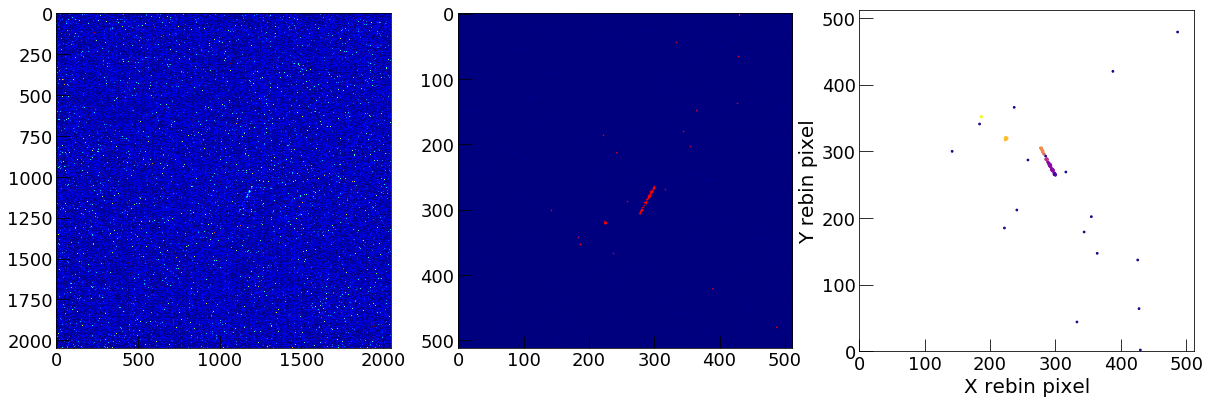

/home/mazzitel/cygnus_lib.py:400: RuntimeWarning: invalid value encountered in double_scalars
  pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])


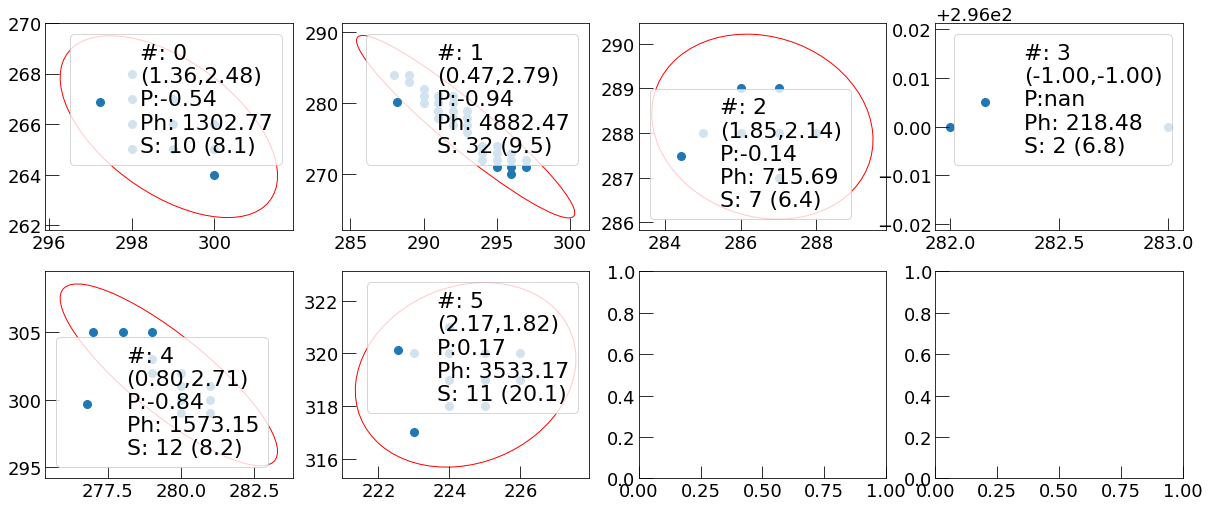

In [63]:
cy.set_atlas_style('square')
from matplotlib import patches
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
#####################################################
# show immage
iTr             = 11
image           = rtnp.hist2array(f.Get(pic[iTr])).T 
fig, ax        = plt.subplots(1,3, figsize=(20, 6))
ax[0].imshow(image, vmin=95,vmax=150, cmap='jet')

rebin_image     = cy.rebin((image-m_image), (rescale, rescale))
rebin_th_image  = cy.rebin((th_image-m_image), (rescale, rescale))
ax[1].imshow(rebin_image, vmin=0, vmax=150, cmap='jet')
edges           = (rebin_image > rebin_th_image) & (rebin_image < cimax)         
points          = np.array(np.nonzero(edges)).T.astype(float) 
ax[1].plot(points[:,1], points[:,0], 'r.', markersize=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(points)

dbscan = DBSCAN(eps=0.05, min_samples = 2) # eps=0.1
dbscan.fit(points)

clusters = dbscan.fit_predict(X_scaled)
ax[2].scatter(points[:,1], points[:,0], s=3, c=dbscan.labels_, cmap="plasma")
ax[2].set_xlabel("X rebin pixel")
ax[2].set_ylabel("Y rebin pixel")
ax[2].set_xlim(0,rebin_image.shape[0])
ax[2].set_ylim(0,rebin_image.shape[1])
plt.show()

for i in range (min(dbscan.labels_), max(dbscan.labels_)):
    ph = 0
    for j in range(0, len(points[:,1][dbscan.labels_==i])):
        ph += (rebin_image[int(points[j,1]), int(points[j,0])])


n_cluster = max(dbscan.labels_)
h_plot    = 4
l_plot    = math.ceil(n_cluster/h_plot)
fig, ax   = plt.subplots(l_plot, h_plot , figsize=(20, l_plot*4))
h_plot_i  = 0
l_plot_i  = 0

for ic in range(0, n_cluster):
    yc = points[:,1][dbscan.labels_==ic]
    xc = points[:,0][dbscan.labels_==ic]

    el_plt, el_par = cy.confidence_ellipse(yc, xc, ax[l_plot_i, h_plot_i], edgecolor='red')
    ph, dim = cy.cluster_par(yc, xc, rebin_image)
    width, height, pearson = cy.confidence_ellipse_par(yc, xc)
    ax[l_plot_i, h_plot_i].scatter(yc, xc, 
                                   label = ('#: %d\n(%.2f,%.2f)\nP:%.2f\nPh: %.2f\nS: %d (%.1f)' %
                                    (ic, width, height, pearson, ph*xyscale*xyscale, dim, ph/dim)))

    ax[l_plot_i, h_plot_i].legend()
    if (h_plot_i==h_plot-1):
        h_plot_i = 0
        l_plot_i +=1
    else:
        h_plot_i +=1
plt.show()


# Show a single cluster

In [ ]:
# show a single cluster
ic = 0
fig, ax = plt.subplots()

ph, dim = cluster_par(points[:,1][dbscan.labels_==ic], points[:,0][dbscan.labels_==ic], rebin_image)
width, height, pearson = confidence_ellipse_par(points[:,1][dbscan.labels_==ic], 
                                                points[:,0][dbscan.labels_==ic])
ax.scatter(points[:,1][dbscan.labels_==ic], points[:,0][dbscan.labels_==ic],
           label = ('#: %d\n(%.2f,%.2f)\nP:%.2f\nPh: %.2f\nS: %d (%.1f)' % 
                    (ic, width, height, pearson, ph*xyscale*xyscale, dim, ph/dim)))
#ax.scatter(points[:,1][dbscan.labels_==ic], points[:,0][dbscan.labels_==ic])
x0, y0, a, b, theta = cluster_elips(points[dbscan.labels_==ic])
confidence_ellipse(points[:,1][dbscan.labels_==ic], points[:,0][dbscan.labels_==ic], ax, edgecolor='red')
#width, height, pearson = confidence_ellipse_par(points[:,1][dbscan.labels_==ic], points[:,0][dbscan.labels_==ic])
print(width, height, pearson)
t = np.linspace(0, 2*np.pi, 100)
print (x0, y0, a, b, theta)
plt.plot(x0 + a*np.cos(t)*np.cos(theta) - b*np.sin(t)*np.sin(theta) , 
         y0 + b*np.sin(t)*np.cos(theta) + a*np.cos(t)*np.sin(theta), 'g-')
plt.grid(color='lightgray',linestyle='--')
plt.legend()
plt.show()

Numbero of immage: 302
0  >> Close and re-Open:  ./tmp.7193.root
Event:  0


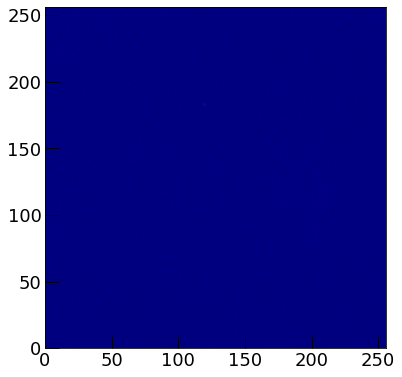

ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required by StandardScaler.

In [24]:
cy.set_atlas_style('square')
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

print ("Numbero of immage: %d"% max_image)

data_to_save = []
files = ("./data/dbscan_run%d_cmin_%d_cmax_%d_rescale_%d_nsigma_%.1f_ev_%d.txt" % 
                 (run, cimin, cimax, rescale, nsigma, max_image))
for iTr in range(0, max_image):
    #
    ##### WARINING next trik has been introduced beocouse of memory garbage og Get ROOT function
    # 150 can be trimmed
    #
    if iTr % 150 == 0:
        print (iTr, ' >> Close and re-Open: ', tmp_file)
        f.Close()
        f  = ROOT.TFile.Open(tmp_file);
    #############################################################################################
    image = rtnp.hist2array(f.Get(pic[iTr])).T

    rebin_image     = cy.rebin(image-m_image, (rescale, rescale))  
    rebin_th_image  = cy.rebin((th_image-m_image), (rescale, rescale))

    edges           = (rebin_image > rebin_th_image) & (rebin_image < cimax)         
    points          = np.array(np.nonzero(edges)).T.astype(float) 
    scaler          = StandardScaler()
    X_scaled        = scaler.fit_transform(points)

    dbscan          = DBSCAN(eps=0.05, min_samples = 2)
    dbscan.fit(points)

    clusters = dbscan.fit_predict(X_scaled)

    for ic in range (min(dbscan.labels_), max(dbscan.labels_)):
        ph = 0.
        # print ("value: ", iTr, ic, dbscan.labels_[ic], min(dbscan.labels_), max(dbscan.labels_))
        yc = points[:,1][dbscan.labels_==ic]
        xc = points[:,0][dbscan.labels_==ic]
        ph, dim = cy.cluster_par(yc, xc, rebin_image)
        width, height, pearson = cy.confidence_ellipse_par(yc,xc)
        for j in range(0, dim):
            x=int(xc[j])
            y=int(yc[j])
            #ph += rebin_image[y,x]
            if j == 0:
                x0start = x
                y0start = y
        x0end = x
        y0end = y
        data_to_save.append([iTr, ic, dim, ph, ph/dim, 
                             x0start, y0start, x0end, y0end, width, height, pearson])

    ###### Debug plots #######################################################################
    if iTr % 20 == 0:
        print ('Event: ', iTr)
        #print ('Saved Data: ', data_to_save[-1])
        plt.imshow(rebin_image, vmin=cimin, vmax=cimax, cmap='jet')
        plt.scatter(points[:,1], points[:,0], s=3, c=dbscan.labels_, cmap="plasma")
        plt.xlim(0,rescale)
        plt.ylim(0,rescale)
        plt.show()
##        n_cluster = max(dbscan.labels_)
##        h_plot    = 4
##        l_plot    = math.ceil(n_cluster/h_plot)
##        fig, ax   = plt.subplots(l_plot, h_plot , figsize=(20, l_plot*4))
##        h_plot_i  = 0
##        l_plot_i  = 0
##        for ic in range(0, n_cluster):
##            yc = points[:,1][dbscan.labels_==ic]
##            xc = points[:,0][dbscan.labels_==ic]
##
##            el_plt, el_par = cy.confidence_ellipse(yc, xc, ax[l_plot_i, h_plot_i], edgecolor='red')
##            ph, dim = cy.cluster_par(yc, xc, rebin_image)
##            width, height, pearson = cy.confidence_ellipse_par(yc, xc)
##            ax[l_plot_i, h_plot_i].scatter(yc, xc, 
##                                           label = ('#: %d\n(%.2f,%.2f)\nP:%.2f\nPh: %.2f\nS: %d (%.1f)' %
##                                            (ic, width, height, pearson, ph*xyscale*xyscale, dim, ph/dim)))
##
##            ax[l_plot_i, h_plot_i].legend()
##            if (h_plot_i==h_plot-1):
##                h_plot_i = 0
##                l_plot_i +=1
##            else:
##                h_plot_i +=1
##        plt.show()


        
files = ("./data/dbscan_run%d_cmin_%d_cmax_%d_rescale_%d_nsigma_%.1f_ev_%d.txt" % 
                 (run, cimin, cimax, rescale, nsigma, max_image))
np.savetxt(files, data_to_save, fmt='%.10e', delimiter=" ")
print ("out file", files)

# Remove downloaded file WARNING

In [27]:
print ("Out file: ", files)
if not cy.rm_file(tmp_file):
    print (">> File "+tmp_file+" removed")

Out file:  ./data/dbscan_run2352_cmin_0_cmax_300_rescale_256_nsigma_1.5_ev_302.txt


In [ ]:
cy.set_atlas_style('square')
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

print ("Numbero of immage: %d"% max_image)

data_to_save = []
files = ("./data/dbscan_run%d_cmin_%d_cmax_%d_rescale_%d_nsigma_%.1f_ev_%d.txt" % 
                 (run, cimin, cimax, rescale, nsigma, max_image))
for iTr in range(0, max_image):
    try:
        image = rtnp.hist2array(f.Get(pic[iTr])).T
            
        rebin_image     = cy.rebin(image-m_image, (rescale, rescale))  
        rebin_th_image  = cy.rebin((th_image-m_image), (rescale, rescale))
        
        edges           = (rebin_image > rebin_th_image) & (rebin_image < cimax)         
        points          = np.array(np.nonzero(edges)).T.astype(float) 
        scaler          = StandardScaler()
        X_scaled        = scaler.fit_transform(points)
    
        dbscan          = DBSCAN(eps=0.05, min_samples = 2)
        dbscan.fit(points)
    
        clusters = dbscan.fit_predict(X_scaled)
    
        for ic in range (min(dbscan.labels_), max(dbscan.labels_)):
            ph = 0.
            # print ("value: ", iTr, ic, dbscan.labels_[ic], min(dbscan.labels_), max(dbscan.labels_))
            yc = points[:,1][dbscan.labels_==ic]
            xc = points[:,0][dbscan.labels_==ic]
            ph, dim = cluster_par(yc, xc, rebin_image)
            width, height, pearson = confidence_ellipse_par(yc,xc)
            for j in range(0, dim):
                x=int(xc[j])
                y=int(yc[j])
                #ph += rebin_image[y,x]
                if j == 0:
                    x0start = x
                    y0start = y
            x0end = x
            y0end = y
            data_to_save.append([iTr, ic, dim, ph, ph/dim, 
                                 x0start, y0start, x0end, y0end, width, height, pearson])
    
    
        if iTr % 20 == 0:
            print ('Event: ', iTr)
            #print ('Saved Data: ', data_to_save[-1])
            plt.imshow(rebin_image, vmin=cimin, vmax=cimax, cmap='jet')
            plt.scatter(points[:,1], points[:,0], s=3, c=dbscan.labels_, cmap="plasma")
            plt.xlim(0,rescale)
            plt.ylim(0,rescale)
            plt.show()
            n_cluster = max(dbscan.labels_)
            h_plot    = 4
            l_plot    = math.ceil(n_cluster/h_plot)
            fig, ax   = plt.subplots(l_plot, h_plot , figsize=(20, l_plot*4))
            h_plot_i  = 0
            l_plot_i  = 0
            for ic in range(0, n_cluster):
                yc = points[:,1][dbscan.labels_==ic]
                xc = points[:,0][dbscan.labels_==ic]
    
                el_plt, el_par = cy.confidence_ellipse(yc, xc, ax[l_plot_i, h_plot_i], edgecolor='red')
                ph, dim = cy.cluster_par(yc, xc, rebin_image)
                width, height, pearson = cy.confidence_ellipse_par(yc, xc)
                ax[l_plot_i, h_plot_i].scatter(yc, xc, 
                                               label = ('#: %d\n(%.2f,%.2f)\nP:%.2f\nPh: %.2f\nS: %d (%.1f)' %
                                                (ic, width, height, pearson, ph*xyscale*xyscale, dim, ph/dim)))
            
                ax[l_plot_i, h_plot_i].legend()
                if (h_plot_i==h_plot-1):
                    h_plot_i = 0
                    l_plot_i +=1
                else:
                    h_plot_i +=1
            plt.show()
    except:
        print ('Event: ', iTr, '<< ERROR')
        
files = ("./data/dbscan_run%d_cmin_%d_cmax_%d_rescale_%d_nsigma_%.1f_ev_%d.txt" % 
                 (run, cimin, cimax, rescale, nsigma, max_image))
np.savetxt(files, data_to_save, fmt='%.10e', delimiter=" ")
print ("out file", files)

# Load file and show plots

In [ ]:
VarNames=["iTr", "cluster_lable", "pixels", "photons", "ph_pixels", "x0start", "y0start", 
          "x0end", "y0end", "width", "height", "pearson"]
C_file = './data/dbscan_run2273_cmin_0_cmax_300_rescale_512_nsigma_1.5_ev_101.txt'
C_file = './data/dbscan_run2277_cmin_0_cmax_300_rescale_512_nsigma_1.5_ev_948.txt'
#C_file = './data/dbscan_run2320_cmin_0_cmax_300_rescale_512_nsigma_1.5_ev_1003.txt'
#C_file = './data/dbscan_run2318_cmin_0_cmax_300_rescale_512_nsigma_1.5_ev_1001.txt'

df = pd.read_csv(C_file, sep=" ", dtype='float64', names=VarNames)
# range
# charge distribution
# charge asimettriy
df['length'] = np.sqrt((df['x0end'] - df['x0start'])**2 + (df['y0end'] - df['y0start'])**2)
df['x0c'] = (df['x0end'] + df['x0start'])/2.
df['y0c'] = (df['y0end'] + df['y0start'])/2.

In [ ]:
df.head()#[df['cluster_lable']==2]
#df.iloc[:,1:4].head()

In [ ]:
df.hist(bins=100, figsize=(20,15), log=True)
plt.show()

# Custs & Normalizzation

In [ ]:

DX = -5
DY = 7
a = 120 # mm
b = 100 # mm

# File Type:
Fe = True


print ("Fidical Ellips: %.2f, %.2f [mm]" % (a,b))


dfc = df[(df['cluster_lable'] > -1) & (df['width'] > 0) & (df['height'] > 0)]
#dfc = dfc[(df['x0start'] > 50) & (df['x0end'] < 200) & (df['y0start'] > 50) & (df['y0end'] < 200)]

dfc.loc[:,'photons']  =dfc['photons']*xyscale*xyscale
dfc.loc[:,'length']   =dfc['length']*rescale_pixelscale
dfc.loc[:,'x0c']      =dfc['x0c']*rescale_pixelscale
dfc.loc[:,'y0c']      =dfc['y0c']*rescale_pixelscale

dfc.hist(bins=100, figsize=(20,15), log=True)
plt.show()



In [ ]:
cy.set_atlas_style('square')
from scipy.optimize import curve_fit
if Fe:
    gauss = True
    pearson_cut = 0.3
else:
    gauss = False
    pearson_cut = 0.7
max_range = 3000
fig, ax = plt.subplots(1,2, figsize=(20, 8))
bins=100
ax[0].hist(dfc['photons'], bins=bins, range=(0,max_range))
ax[0].hist(dfc['photons'][abs(dfc['pearson'])<pearson_cut], bins=bins, range=(0,max_range), color='red', 
           alpha=0.6, label = ('pearson<%.1f'%pearson_cut))

ax[0].set_xlabel("Photons")
if gauss:
    cmin    = 1500
    cmax    = 2500
    y = dfc['photons'][abs(dfc['pearson'])<pearson_cut]
    y = y[y<max_range]
    binsf = int(bins*((cmax-cmin)/(y.max()-y.min())))
    print (binsf, bins, (cmax-cmin)/(y.max()-y.min()), y.max(), y.min())
    yh, bins_edge = np.histogram(y, bins=binsf, range=(cmin,cmax))
    sum_yh   = float(sum(yh))
    x       = np.linspace(cmin, cmax, binsf)
    ye      = 1/np.sqrt(yh)
    #ax[0].errorbar(x, yh, ye, fmt="k.")
    A, M, S = yh.max(), y.mean(), y.std()

    popt, pcov = curve_fit(my.Gauss3, x, yh, 
                            sigma=ye,
                            absolute_sigma=True,
                            p0=(A, M, S))
    xf = np.linspace(cmin, cmax, 100)
    ax[0].plot(xf, my.Gauss3(xf, *popt), 'k-', label='Gauss\nA = %.2e\nM = %.2e\nS = %.2e' % 
                          (popt[0], popt[1], popt[2]))
    ph_f = popt[1]
    ax[0].legend()
    
bins=100
ax[0].legend()
ax[1].hist(dfc['ph_pixels'], bins=bins, range=(0,20))
ax[1].hist(dfc['ph_pixels'][abs(dfc['pearson'])>pearson_cut], bins=bins, color='red', range=(0,20),
           alpha=0.6, label = ('pearson<%.1f'%pearson_cut))

ax[1].set_xlabel("Photons/pixels")
ax[1].legend()
plt.show()
fig, ax = plt.subplots(1,2, figsize=(20, 8))
#ax[0].hist(np.log(dfc['ph_pixels']*(dfc['length'][dfc['length']>0])), bins=100, 
#           color='r')
#ax[0].set_xlabel("pearson")
#ax[0].set_xlabel(r"$\eta = log (\frac {photons/pixel} {length})$")
ax[0].hist(abs(dfc['pearson']), bins=200, 
           color='r')
ax[1].hist(np.log(dfc['ph_pixels']/abs(dfc['pearson'])[abs(dfc['pearson'])>0]), bins=100, range=(0,10))
ax[1].set_xlabel(r"$\eta = log (\frac {photons/pixel} {pearson})$")
#ax[1].set_ylabel("ph_pixels")
plt.show()
#fig, ax = plt.subplots(1,2, figsize=(20, 8))
#ax[0].plot(abs(dfc['pearson']), dfc['length'], 'r.')
#ax[0].set_xlabel(r"pearson")
#ax[0].set_ylabel(r"length [mm]")
#ax[1].plot(abs(dfc['pearson']),np.log(dfc['ph_pixels']*(dfc['length'][dfc['length']>0])), 
#           'b.')
#plt.show()
#fig, ax = plt.subplots(1,2, figsize=(20, 8))
#ax[0].plot(abs(dfc['pearson']), dfc['photons'], 'r.')
#ax[0].set_xlabel(r"pearson")
#ax[0].set_ylabel(r"photons")
#ax[1].plot(abs(dfc['pearson']),dfc['ph_pixels'], 'b.')
#ax[1].set_xlabel(r"pearson")
#ax[1].set_ylabel(r"ph_pixels")
#plt.show()
eta_cut = 2.8
fig, ax = plt.subplots(1,2, figsize=(20, 8))
ax[0].hist(dfc['photons'], bins=bins, range=(0,max_range))
eta = np.log(dfc['ph_pixels']/abs(dfc['pearson'])[abs(dfc['pearson'])>0])
ax[0].hist(dfc['photons'][eta>eta_cut], bins=bins, range=(0,max_range), color='red', 
           alpha=0.6)
ax[0].set_xlabel(r"$\eta = log (\frac {photons/pixel} {pearson})$>%.1f" % eta_cut)
ax[1].hist(dfc['photons'][eta>eta_cut], bins=bins, range=(0,max_range), color='black')
plt.show()

In [ ]:
#plt.plot(df['y0start'], df['x0start'], 'k.', markersize=1)
import seaborn as sns
######################
### se lo vuoi dal prcedente fit
if Fe:
    phKev = ph_f/5.9
#####################
y = dfc['y0c']
x = dfc['x0c']
l = dfc['length']
e = dfc['photons']/phKev
fig, ax = plt.subplots(1,2, figsize=(20, 8))
ax[0].plot(y, x, 'r.', markersize=3)
ax[0].set_xlabel("X [mm]")
ax[0].set_ylabel("Y [mm]")
ax[1].plot(e, l, 'k.', markersize=3)
ax[1].set_xlabel("Energy [keV]")
ax[1].set_ylabel("length [mm]")
plt.show()
fig, ax = plt.subplots(1,2, figsize=(20, 8))
#ax[0].scatter(df['width'],df['height'],df['pixels']/10 )
#ax[0].set_xlabel("width")
#ax[0].set_ylabel("height")
#ax[0].hist2d(e[(e<10)], dfc['pearson'][(e<10)], bins=(10,10), cmap=plt.cm.jet)
sns.kdeplot(e[(e<10)], dfc['pearson'][(e<10)], ax=ax[0], cmap="Blues", shade=True, shade_lowest=True, )
ax[0].set_xlabel("Energy [keV]")
#ax[1].plot(e[e<20], l[e<20], 'k.', markersize=5)
ax[1].hist2d(e[(e<10) & (l<5)], l[(e<10) & (l<5)], bins=(20,10), cmap=plt.cm.jet)
ax[1].set_xlabel("Energy [keV]")
ax[1].set_ylabel("length [mm]")
plt.show()

# Analsi comparata

In [ ]:
VarNames=["iTr", "cluster_lable", "pixels", "photons", "ph_pixels", "x0start", "y0start", 
          "x0end", "y0end", "width", "height", "pearson"]
#######################
#C_file = './data/dbscan_run1514_cmin_95_cmax_300_rescale_256_rebin_th_image_116_ev_100.txt' # AmBe 450
#C_file = './data/dbscan_run1514_cmin_95_cmax_300_rescale_256_rebin_th_image_117_ev_100.txt' # AmBe 450
#C_file = './data/dbscan_run1514_cmin_95_cmax_300_rescale_256_rebin_th_image_120_ev_100.txt' # AmBe 450
#C_file = './data/dbscan_run494_cmin_95_cmax_300_rescale_256_rebin_th_image_105_ev_100.txt' # AmBe ORANGE 440
C_file = './data/dbscan_run494_cmin_0_cmax_300_rescale_256_rebin_th_image_5_ev_100.txt' # AmBe ORANGE 440
C_file = './data/dbscan_run740_cmin_0_cmax_300_rescale_512_rebin_th_image_5_ev_100.txt' # AmBe LEMON 450
ambe = pd.read_csv(C_file, sep=" ", dtype='float64', names=VarNames).replace([np.inf, -np.inf], 5)
########################
#C_file = './data/dbscan_run725_cmin_95_cmax_300_rescale_256_rebin_th_image_101_ev_100.txt' # Co60 LEMON 450
C_file = './data/dbscan_run722_cmin_0_cmax_300_rescale_256_rebin_th_image_2_ev_100.txt' # Co60 ORANGE 440
C_file = './data/dbscan_run725_cmin_0_cmax_300_rescale_512_rebin_th_image_6_ev_100.txt' # Co60 LEMON 450
co60 = pd.read_csv(C_file, sep=" ", dtype='float64', names=VarNames)
ambe['length'] = np.sqrt((ambe['x0end'] - ambe['x0start'])**2 + (ambe['y0end'] - ambe['y0start'])**2)
ambe['x0c'] = (ambe['x0end'] + ambe['x0start'])/2.
ambe['y0c'] = (ambe['y0end'] + ambe['y0start'])/2.

co60['length'] = np.sqrt((co60['x0end'] - co60['x0start'])**2 + (co60['y0end'] - co60['y0start'])**2)
co60['x0c'] = (co60['x0end'] + co60['x0start'])/2.
co60['y0c'] = (co60['y0end'] + co60['y0start'])/2.

ambe.loc[:,'photons']  = ambe['photons']*xyscale*xyscale
ambe.loc[:,'length']   = ambe['length']*rescale_pixelscale
ambe.loc[:,'x0c']      = ambe['x0c']*rescale_pixelscale
ambe.loc[:,'y0c']      = ambe['y0c']*rescale_pixelscale
co60.loc[:,'photons']  = co60['photons']*xyscale*xyscale
co60.loc[:,'length']   = co60['length']*rescale_pixelscale
co60.loc[:,'x0c']      = co60['x0c']*rescale_pixelscale
co60.loc[:,'y0c']      = co60['y0c']*rescale_pixelscale

ambe['energy']         = ambe['photons']/phKev
co60['energy']         = co60['photons']/phKev

ambe = ambe[(ambe['cluster_lable'] > -1) & (ambe['width'] > 0) & (ambe['height'] > 0) & (ambe['ph_pixels'] < 30)]
co60 = co60[(co60['cluster_lable'] > -1) & (co60['width'] > 0) & (co60['height'] > 0) & (co60['ph_pixels'] < 30)]

In [ ]:

fig, ax = plt.subplots(1,2, figsize=(20, 8))
ax[0].plot(ambe['energy'], ambe['length'], 'b.', markersize=3, label='AmBe')
ax[0].plot(co60['energy'], co60['length'], 'r.', markersize=3, alpha=0.8, label='Co60')
ax[1].plot(ambe['energy'], ambe['length'], 'b.', markersize=3, label='AmBe')
ax[1].plot(co60['energy'], co60['length'], 'r.', markersize=3, alpha=0.8, label='Co60')

#plt.plot(cosmic['photons']/phKev, cosmic['length']*rescale_pixelscale, 'g.', markersize=2, alpha=0.4)

ax[0].set_xlabel("Energy [keV]")
ax[0].set_ylabel("length [mm]")
ax[1].set_xlabel("Energy [keV]")
ax[1].set_ylabel("length [mm]")

ax[1].set_xlim(0,30)
ax[1].set_ylim(0,10)
ax[0].legend()
ax[1].legend()


plt.show()

p_cor = 0.7

fig, ax = plt.subplots(1,2, figsize=(20, 8))
ax[0].plot(ambe['energy'][abs(ambe['pearson'])>p_cor], ambe['length'][abs(ambe['pearson'])>p_cor], 
           'b.', markersize=3, label=('AmBe pearson > %.2f' % p_cor))
ax[0].plot(co60['energy'][abs(co60['pearson'])>p_cor], co60['length'][abs(co60['pearson'])>p_cor], 
           'r.', markersize=3, alpha=0.8, label=('Co60 pearson > %.2f' % p_cor))
ax[1].plot(ambe['energy'][abs(ambe['pearson'])>p_cor], ambe['length'][abs(ambe['pearson'])>p_cor], 
           'b.', markersize=3, label=('AmBe pearson > %.2f' % p_cor))
ax[1].plot(co60['energy'][abs(co60['pearson'])>p_cor], co60['length'][abs(co60['pearson'])>p_cor], 
           'r.', markersize=3, alpha=0.8, label=('Co60 pearson > %.2f' % p_cor))


ax[0].set_xlabel("Energy [keV]")
ax[0].set_ylabel("length [mm]")
ax[1].set_xlabel("Energy [keV]")
ax[1].set_ylabel("length [mm]")

ax[1].set_xlim(0,30)
ax[1].set_ylim(0,10)
ax[0].legend()
ax[1].legend()


plt.show()

fig, ax = plt.subplots(1,2, figsize=(20, 8))

#ax[0].hist(ambe['length']*rescale_pixelscale, bins=100, color='b')
#ax[0].hist(co60['length']*rescale_pixelscale, bins=100, color='r', alpha=0.6)
ax[0].hist(np.log(ambe['ph_pixels']/(ambe['length'][ambe['length']>0])), bins=50,
           color='b', label='AmBe')
ax[0].hist(np.log(co60['ph_pixels']/(co60['length'][co60['length']>0])), bins=50, 
           color='r', alpha=0.6, label='Co60')

ax[0].set_xlabel(r"$\chi = log (\frac {photons/pixels} {length})$")




eta_ambe = np.log((ambe['ph_pixels']*abs(ambe['pearson']))[abs(ambe['pearson'])>p_cor])
eta_co60 = np.log((co60['ph_pixels']*abs(co60['pearson']))[abs(co60['pearson'])>p_cor])

ax[1].hist(eta_ambe, label=('AmBe pearson > %.2f' % p_cor), bins=50, color='b')
ax[1].hist(eta_co60,label=('Co60 pearson > %.2f' % p_cor), bins=50, color='r', alpha=0.6)

ax[1].set_xlabel(r"$\eta = log (\frac {photons} {pixels} \times {pearson})$")

ax[0].legend()
ax[1].legend()

plt.show()

fig, ax = plt.subplots(1,2, figsize=(20, 8))
ax[0].plot(abs(ambe['pearson'][abs(ambe['pearson'])>p_cor]), 
           eta_ambe, 
           'b.', markersize=3, label=('AmBe pearson > %.2f' % p_cor))
ax[0].plot(abs(co60['pearson'][abs(co60['pearson'])>p_cor]), 
           eta_co60,
           'r.', markersize=3, alpha=0.8, label=('Co60 pearson > %.2f' % p_cor))


ambe_h, ambe_bins = np.histogram(eta_ambe, 
                            bins=40, range=(-4,5))
co60_h, co60_bins = np.histogram(eta_co60, 
                            bins=40, range=(-4,5))

ene_h, ene_bins = np.histogram((ambe['energy'][abs(ambe['pearson'])>p_cor]), 
                            bins=40, range=(-4,5))

ax[0].set_xlabel("pearson")
ax[0].set_ylabel(r"$\eta$")
#ax[1].bar(ambe_bins[:-1], ambe_h, width=0.3, color='b')
#ax[1].bar(co60_bins[:-1], co60_h, width=0.3, color='r', alpha=0.8)
detec_eff = (ambe_h[ambe_h>0]-co60_h[ambe_h>0])/ambe_h[ambe_h>0]

detec_bins = ambe_bins[:-1][ambe_h>0]
ax[1].plot(detec_bins, detec_eff,'k-', label=('pearson > %.2f' % p_cor))
#ax[0].set_ylim(0,100)

#ax[1].set_xlabel("Energy [keV]")
#ax[1].set_ylabel(r"$\eta$")

#ax[1].set_xlim(0,30)
ax[1].set_ylim(0,1.1)
ax[0].legend()
ax[1].legend()

plt.show()



In [ ]:
#iTrC = (ambe[['iTr', 'cluster_lable']])[abs(ambe['pearson'])>p_cor][(eta_ambe>1.5) & (eta_ambe<2)]
iTrC = (ambe[['iTr', 'cluster_lable']])[(ambe['ph_pixels']>10) & (abs(ambe['pearson'])>pearson_cut)]
#print (iTrC)
Tr = np.array(iTrC['iTr'])
ic = np.array(iTrC['cluster_lable'])
print (len(Tr))
for iTr in range(0, len(Tr)):
    fig, ax = plt.subplots(1,2, figsize=(20, 8))
    image = cy.swift_read_image_h5(cy.imageFile2FullPathCygnus(dataSelection, run, Tr[iTr]))
    
    rebin_image     = cy.rebin(image-m_image, (rescale, rescale))  
    
    edges           = (rebin_image > rebin_th_image) & (rebin_image < cimax)         
    points          = np.array(np.nonzero(edges)).T.astype(float) 
    scaler          = StandardScaler()
    X_scaled        = scaler.fit_transform(points)

    dbscan          = DBSCAN(eps=0.05, min_samples = 2)
    dbscan.fit(points)

    clusters = dbscan.fit_predict(X_scaled)

    print ('Imege: ', Tr[iTr])
    ax[0].imshow(rebin_image, vmin=cimin, vmax=cimax, cmap='jet')
    ax[0].scatter(points[:,1], points[:,0], s=3, c=dbscan.labels_, cmap="plasma")
    ax[0].set_xlim(0,rescale)
    ax[0].set_ylim(0,rescale)
    
    yc = points[:,1][dbscan.labels_==ic[iTr]]
    xc = points[:,0][dbscan.labels_==ic[iTr]]
    el_plt, el_par = confidence_ellipse(yc, xc, ax[0], edgecolor='white')
    el_plt, el_par = confidence_ellipse(yc, xc, ax[1], edgecolor='red')
    ph, dim = cy.cluster_par(yc, xc, rebin_image)
    width, height, pearson = cy.confidence_ellipse_par(yc, xc)
    ax[1].scatter(yc, xc, 
                                   label = ('#: %d\n(%.2f,%.2f)\nP:%.2f\nPh: %.2f\nS: %d (%.1f)' %
                                    (ic[iTr], width, height, pearson, ph*xyscale*xyscale, dim, ph/dim)))
    ax[1].legend()
    plt.show()

In [ ]:
Tr = np.array(iTrC['iTr'])
Tr[0]

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20, 8))
ax[0].hist(np.log(ambe['ph_pixels']/(ambe['length'][ambe['length']>0])), bins=100, 
           color='b', label='AmBe')
ax[0].hist(np.log(co60['ph_pixels']/(co60['length'][co60['length']>0])), bins=100, 
           color='r', alpha=0.6, label='Co60')

ax[0].set_xlabel("pearson")
ax[0].set_xlabel(r"$\eta = log (\frac {photons/pixel} {length})$")
ax[1].hist(np.log(ambe['ph_pixels']/abs(ambe['pearson'])[ambe['pearson']>0]), bins=100, 
           color='b', label='AmBe', range=(0, 10))
ax[1].hist(np.log(co60['ph_pixels']/abs(co60['pearson'])[co60['pearson']>0]), bins=100, 
           color='r', alpha=0.6, label='Co60', range=(0, 10))
ax[1].set_xlabel(r"$\eta = log (\frac {photons/pixel} {pearson})$")
ax[0].legend()
ax[1].legend()
#ax[1].set_ylabel("ph_pixels")
plt.show()
fig, ax = plt.subplots(1,2, figsize=(20, 8))
ax[0].plot(abs(ambe['pearson']), ambe['length']*rescale_pixelscale, 'b.', label='AmBe')
ax[0].plot(abs(co60['pearson']), co60['length']*rescale_pixelscale, 'r.', label='Co60')
ax[0].set_xlabel(r"pearson")
ax[0].set_ylabel(r"length [mm]")
ax[1].plot(abs(ambe['pearson']),np.log(ambe['ph_pixels']/(ambe['length'][ambe['length']>0]*rescale_pixelscale)), 
           'b.', label='AmBe')
ax[1].plot(abs(co60['pearson']),np.log(co60['ph_pixels']/(co60['length'][co60['length']>0]*rescale_pixelscale)), 
           'r.', alpha=0.6, label='Co60')
ax[0].legend()
ax[1].legend()
plt.show()

In [ ]:
ambe_h, ambe_bins = np.histogram(np.log(ambe['ph_pixels']/(ambe['length'][ambe['length']>0])), 
                            bins=24, range=(0,6))
co60_h, co60_bins = np.histogram(np.log(co60['ph_pixels']/(co60['length'][co60['length']>0])), 
                            bins=24, range=(0,6))

In [ ]:
plt.bar(ambe_bins[:-1], ambe_h, width=0.1, color='b')
plt.bar(co60_bins[:-1], co60_h, width=0.1, color='r', alpha=0.6)
plt.plot((3.95, 3.95), (0,1500), 'g')
plt.xlim(0,6)
plt.show()

In [ ]:
co60_bins[:-1][co60_h==0]

In [ ]:
co60_bins

In [ ]:
#np.where(co60_bins==3.95)[0][0]
print("Contminazione: ", co60_h[co60_bins[:-1]>3.95].sum()/ambe_h[ambe_bins[:-1]>3.95].sum())

In [ ]:
co60_h_cut=np.copy(co60_h)
co60_h_cut[co60_bins[:-1]>3.95]=0

In [ ]:
detec_eff = (ambe_h[ambe_h>0]-co60_h[ambe_h>0])/ambe_h[ambe_h>0]
detec_eff_cut = (ambe_h[ambe_h>0]-co60_h_cut[ambe_h>0])/ambe_h[ambe_h>0]

detec_bins = ambe_bins[:-1][ambe_h>0]
plt.plot(detec_bins, detec_eff_cut, color='k')
plt.plot(detec_bins, detec_eff, color='r')
plt.xlim(3,5)
plt.show()

In [ ]:
len(detec_eff)

In [ ]:
np.exp(3.95)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20, 8))
ax[0].bar(ambe_bins[:-1], ambe_h, width=0.1, color='b', label='AmBe')
ax[0].bar(co60_bins[:-1], co60_h, width=0.1, color='r', alpha=0.6, label='Co60')
ax[0].plot((3.95, 3.95), (0,1500), 'g')
ax[0].set_xlim(0,5)
ax[0].legend()
ax[1].plot(detec_bins, detec_eff_cut, color='k', label=r'cut $\eta < 3.95$')
ax[1].plot(detec_bins, detec_eff, color='r', label='all data')
ax[1].set_xlim(3,5)
ax[1].legend()
ax[0].set_xlabel(r"$\eta = log (\frac {photons/pixel} {length})$")
ax[1].set_xlabel(r"$\eta = log (\frac {photons/pixel} {length})$")
plt.show()

In [ ]:
d = np.linspace(0, 80, 80)
lenght = d/np.exp(3.95)

In [ ]:
plt.plot(lenght, d)
plt.xlabel(r"length [mm]")
plt.ylabel(r"density [ph/pixel]")
plt.show()